# Pareto-NBD model

Comparison with lifetimes



#### References:
----------
David C. Schmittlein, Donald G. Morrison and Richard Colombo
Management Science,Vol. 33, No. 1 (Jan., 1987), pp. 1-24
"Counting Your Customers: Who Are They and What Will They Do Next,"
    
Fader, Peter & G. S. Hardie, Bruce (2005).
["A Note on Deriving the Pareto/NBD Model and Related Expressions."](http://brucehardie.com/notes/009/pareto_nbd_derivations_2005-11-05.pdf)

In [13]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import numpy as np
import warnings

In [14]:
from pymc_marketing.clv.models.pareto_nbd import ParetoNBDModel
from pymc_marketing.clv.distributions import ParetoNBD

In [15]:
# Extra dependency for this notebook
from lifetimes.datasets import load_cdnow_summary
from lifetimes import ParetoNBDFitter

## Load data

In [16]:
df = load_cdnow_summary(index_col=[0])
df.head()

,frequency,recency,T
ID,,,
1,2,30.43,38.86
2,1,1.71,38.86
3,0,0.00,38.86
4,0,0.00,38.86
5,0,0.00,38.86


In [17]:
df.shape

(2357, 3)

In [18]:
x = df["frequency"].values
t_x = df["recency"].values
T = df["T"].values

## Lifetimes implementation

In [19]:
ParetoNBDFitter().fit(x, t_x, T)

<lifetimes.ParetoNBDFitter: fitted with 2357 subjects, alpha: 10.58, beta: 11.67, r: 0.55, s: 0.61>

In [20]:
fit = {"r": 0.55, "alpha": 10.58, "s": 0.61, "beta": 11.67}

In [21]:
ParetoNBDFitter._conditional_log_likelihood(list(fit.values()), x, t_x, T).sum()

-9595.008530490335

## PyMC-Marketing Implementation

Weibull default priors. For an interactive PDF go here:
https://homepage.divms.uiowa.edu/~mbognar/applets/weibull.html

<AxesSubplot:ylabel='Density'>

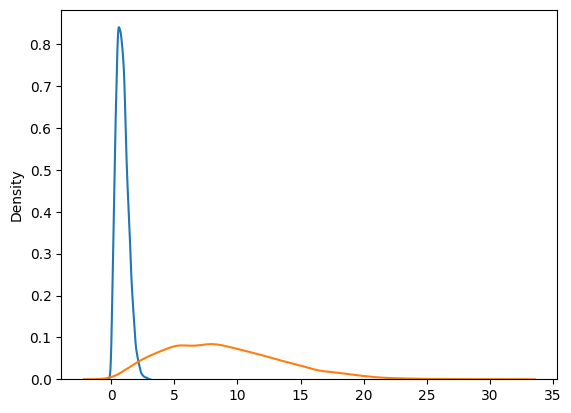

In [22]:
shape_prior = pm.draw(pm.Weibull.dist(alpha=2,beta=1, size=10_000))
scale_prior = pm.draw(pm.Weibull.dist(alpha=2,beta=10, size=10_000))

sns.kdeplot(shape_prior)
sns.kdeplot(scale_prior)


In [82]:
with pm.Model() as m1:
    r = pm.Weibull("r",alpha=2, beta=1)
    alpha = pm.Weibull("alpha", alpha=2, beta=10)
    s = pm.Weibull("s",alpha=2, beta=1)
    beta = pm.Weibull("beta", alpha=2, beta=10)
    llike = ParetoNBD("llike", r=r, alpha=alpha, s=s, beta=beta, T=T, observed=np.stack((t_x, x), axis=1))

In [60]:
pm.logp(llike, np.stack((t_x, x), axis=1)).sum().eval(dict(zip((r, alpha, s, beta), fit.values())))

array(-9595.00853049)

In [64]:
with m1:
    with warnings.catch_warnings():
        warnings.filterwarnings(
                action='ignore',
                category=UserWarning)       
        idata = pm.sample(step=pm.Slice())

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [r]
>Slice: [alpha]
>Slice: [s]
>Slice: [beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


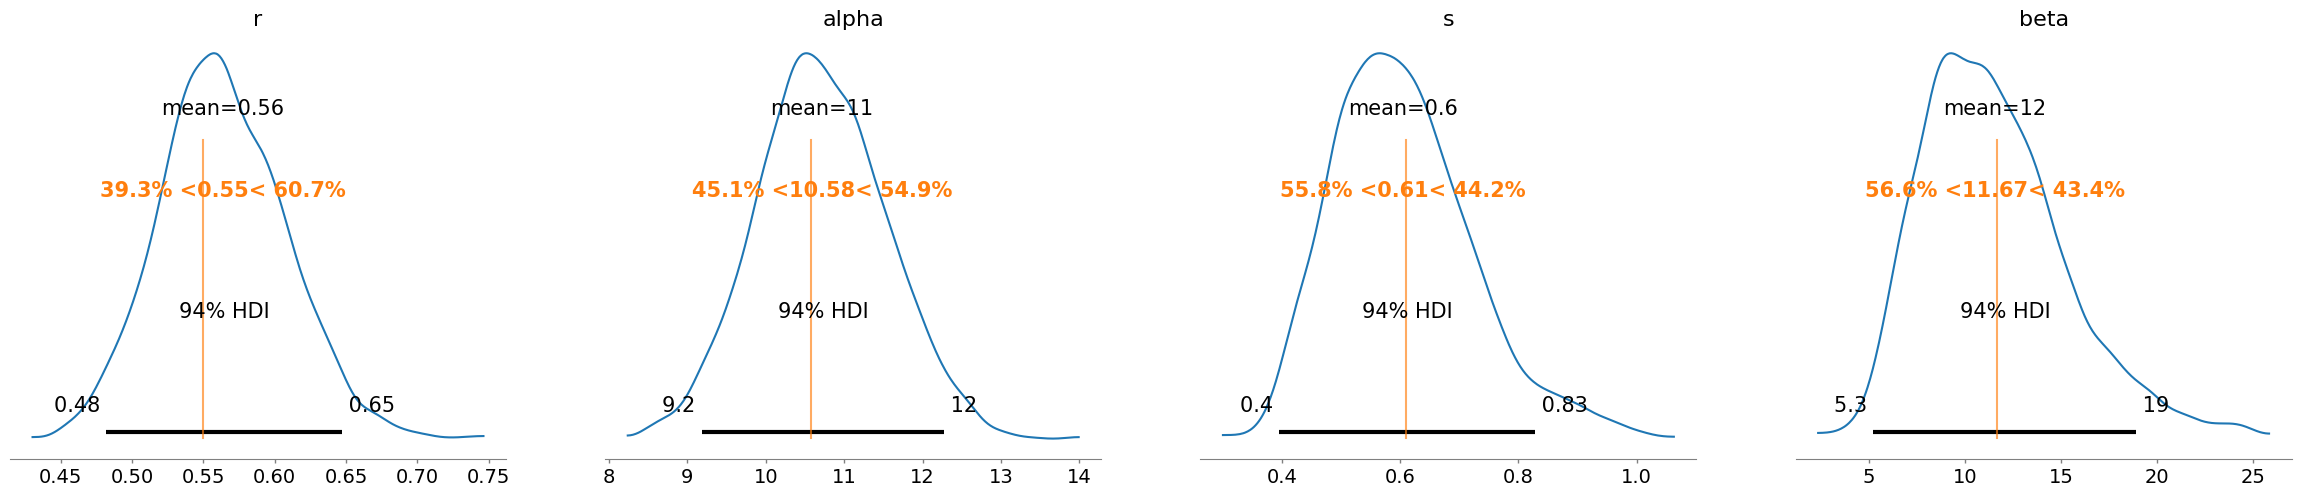

In [21]:
az.plot_posterior(idata, ref_val=list(fit.values()));

In [80]:
with warnings.catch_warnings():
    warnings.filterwarnings(
            action='ignore',
            category=UserWarning)       

    pnbd = ParetoNBDModel(df.index,x,t_x,T)

    #pnbd.fit(fit_method='map')
    
with pnbd.model:

    pnbd.fit(step=pm.Slice(), draws=600, tune=1000)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [r]
>Slice: [alpha]
>Slice: [s]
>Slice: [beta]


Sampling 4 chains for 1_000 tune and 600 draw iterations (4_000 + 2_400 draws total) took 17 seconds.


In [81]:
#az.plot_bpv(idata, kind="t_stat", t_stat="0.5")

# why isn't rhat showing up?
pnbd.fit_summary()
#plt.show()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r,0.579,0.035,0.511,0.642,0.002,0.001,487.0,761.0,1.01
alpha,10.620,0.546,9.646,11.637,0.022,0.016,611.0,944.0,1.01
s,0.598,0.049,0.509,0.693,0.002,0.001,713.0,1014.0,1.00
beta,10.181,0.872,8.581,11.808,0.028,0.020,962.0,1061.0,1.00


## Drawing from distribution (4 times as much data)

In [17]:
fit

{'r': 0.55, 'alpha': 10.58, 's': 0.61, 'beta': 11.67}

In [19]:
draws = pm.draw(ParetoNBD.dist(**fit, T=T.mean(), size=10_000))
draws.shape

(10000, 2)

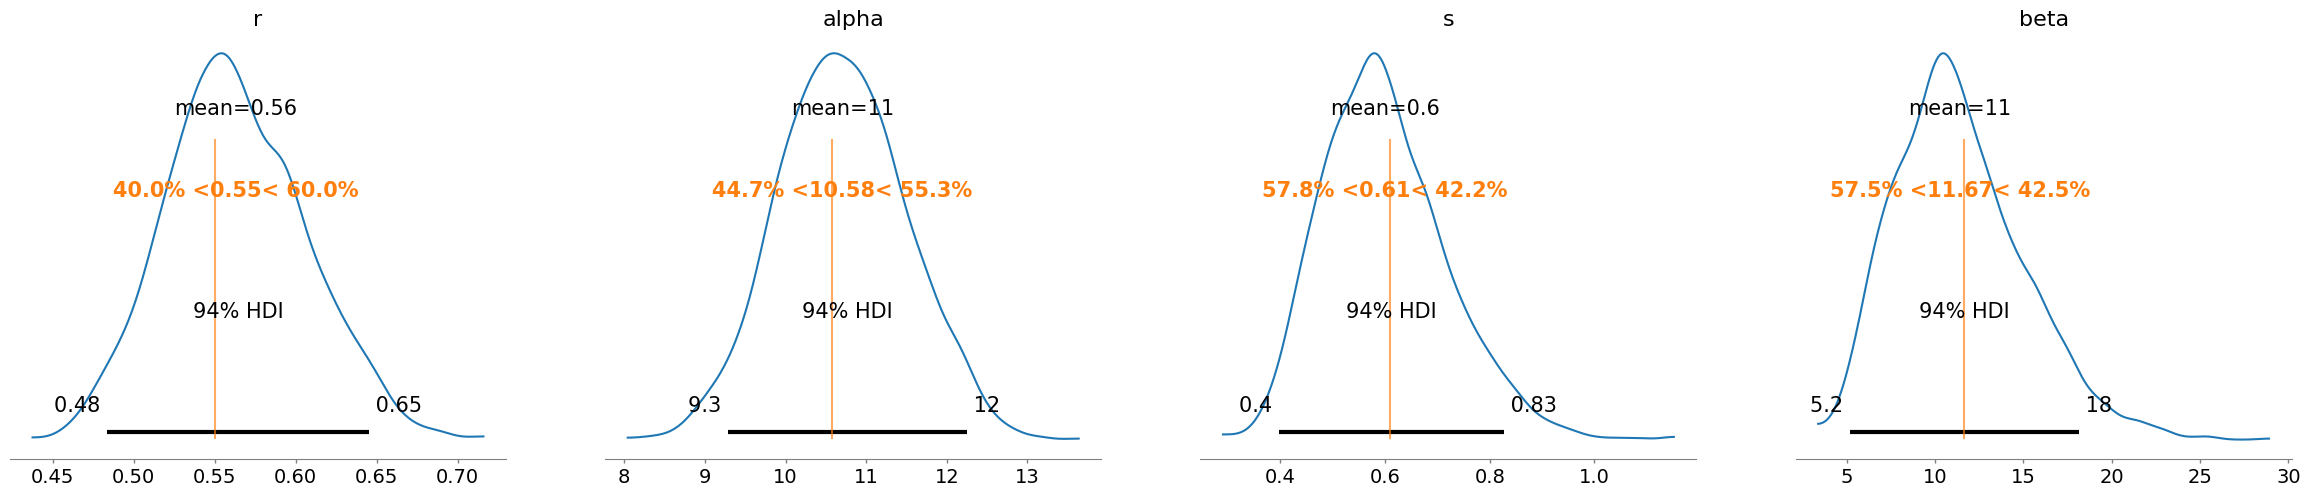

In [47]:
az.plot_posterior(idata, ref_val=list(fit.values()));

In [22]:
# with m2:
#     with warnings.catch_warnings():
#         warnings.filterwarnings(
#             action='ignore',
#             category=UserWarning,
#             message='Rewrite warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.'
#         )   
        
#         warnings.filterwarnings(
#             action='ignore',
#             category=UserWarning,
#             message='Rewrite warning: The Op hyp2f1_der does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.'
#         )   
        
#         idata = pm.sample(initvals=fit, init="adapt_diag")  # takes ages to sample

## Testing MAP

In [31]:
fit

{'r': 0.55, 'alpha': 10.58, 's': 0.61, 'beta': 11.67}

In [27]:
with m1:
    with warnings.catch_warnings():
        warnings.filterwarnings(
            action='ignore',
            category=UserWarning,
            message='Rewrite warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.'
        )   
        
        warnings.filterwarnings(
            action='ignore',
            category=UserWarning,
            message='Rewrite warning: The Op hyp2f1_der does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.'
        )  
        res = pm.find_MAP()

In [28]:
{k: res[k] for k in fit}

{'r': array(0.55961892),
 'alpha': array(10.59116019),
 's': array(0.55028984),
 'beta': array(9.75557741)}